# Time series analysis of sentiments in period of time

In [186]:
import pandas as pd
import numpy as np
import statsmodels.tsa.arima_model as stm
import plotly.express as px
import plotly.graph_objs as go
import kaleido
import arch
import datetime
import math
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as stm_plots
%matplotlib inline

## Loading data and features extraction

In [105]:
df_1 = pd.read_csv('tweets_sentiments.csv')
df_2 = pd.read_csv('output.csv')

In [106]:
df_1.head(10)

,Text,Tension
0,bardzo ciekawa według miąć opracować,0
1,jeden z powód dla który wysyłać tak duży pomoc...,-1
2,przekazać jugosłowiański czołg bojowy ten wari...,0
3,przekazać jugosłowiański czołg bojowy ten wari...,0
4,clip,0
5,minuta w parlament europejski,0
6,przekazać jugosłowiański czołg bojowy ten wari...,0
7,przekazać jugosłowiański czołg bojowy ten wari...,0
8,zgodzić siebie na zakup ciężki bronić do bezpł...,0
9,minuta w parlament europejski,0


In [107]:
df_2.head(10)

,Unnamed: 0,id,text,retweet_count,created_at,author,location,is_verified
0,0.0,1517289557741477890,"Bardzo ciekawe, według mnie, opracowanie #Ukra...",0,2022-04-21 23:49:55+00:00,AntoniPiechocki,NaN,False
1,1.0,1517284025928495104,"RT @propeertys: Jednym z powodów, dla których ...",18,2022-04-21 23:27:56+00:00,52_macius,Poznań Stare Miasto / EU,False
2,2.0,1517281903241482241,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:19:30+00:00,KozlowskiMarek,Wrocław,False
3,3.0,1517281417943736321,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:17:34+00:00,lucinda_10,NaN,False
4,4.0,1517280783345635329,.2345z #PeerTube CLIP https://t.co/OnDvp8AxN0 ...,0,2022-04-21 23:15:03+00:00,BastardHegels,NaN,False
5,5.0,1517280086541717504,RT @dabrowska_hf: 7 minut w Parlamencie Europe...,9,2022-04-21 23:12:16+00:00,karolk18,NaN,False
6,6.0,1517279847885774852,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:11:20+00:00,MarioRebeliant,Poland,False
7,7.0,1517279637080100865,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:10:29+00:00,52_macius,Poznań Stare Miasto / EU,False
8,8.0,1517279617647882241,RT @propeertys: UE zgodziła się na zakup ciężk...,44,2022-04-21 23:10:25+00:00,djankowski10,NaN,False
9,9.0,1517279343763984384,RT @dabrowska_hf: 7 minut w Parlamencie Europe...,9,2022-04-21 23:09:19+00:00,RenataJasinskaG,"Płock, Polska",False


We need to parse dates

In [108]:
# Let's parse dates
parse_dates = lambda x : x[:-6]

df_2['created_at'] = df_2['created_at'].apply(parse_dates)
df_2.head()

,Unnamed: 0,id,text,retweet_count,created_at,author,location,is_verified
0,0.0,1517289557741477890,"Bardzo ciekawe, według mnie, opracowanie #Ukra...",0,2022-04-21 23:49:55,AntoniPiechocki,NaN,False
1,1.0,1517284025928495104,"RT @propeertys: Jednym z powodów, dla których ...",18,2022-04-21 23:27:56,52_macius,Poznań Stare Miasto / EU,False
2,2.0,1517281903241482241,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:19:30,KozlowskiMarek,Wrocław,False
3,3.0,1517281417943736321,RT @propeertys: 🇸🇮Słowenia przekaże 🇺🇦Ukrainie...,17,2022-04-21 23:17:34,lucinda_10,NaN,False
4,4.0,1517280783345635329,.2345z #PeerTube CLIP https://t.co/OnDvp8AxN0 ...,0,2022-04-21 23:15:03,BastardHegels,NaN,False


In [109]:
# We should take created_at column from df_2 and Tension columns from df_1 and create new data frame which will be time series
ts = pd.DataFrame(data = np.array(df_1['Tension']), index = df_2['created_at'], columns = ['Tension'])
ts = ts.sort_index(ascending = True)
ts.head(10)

,Tension
created_at,
2022-04-15 21:02:01,-1
2022-04-15 21:02:23,-1
2022-04-15 21:04:04,0
2022-04-15 21:04:19,0
2022-04-15 21:04:21,-1
2022-04-15 21:05:14,-1
2022-04-15 21:05:17,-1
2022-04-15 21:05:58,0
2022-04-15 21:06:49,1


In [110]:
# We need to make moving sum

def moving_sum(pd_series):
    """Function returns array-like object with moving sum of pd_series"""
    
    s = 0
    result = []
    
    for element in pd_series:
        s += element
        result.append(s)
        
    return result

ts['moving_tension'] = moving_sum(ts['Tension'])

del ts['Tension']

In [111]:
ts.head(10)

,moving_tension
created_at,
2022-04-15 21:02:01,-1
2022-04-15 21:02:23,-2
2022-04-15 21:04:04,-2
2022-04-15 21:04:19,-2
2022-04-15 21:04:21,-3
2022-04-15 21:05:14,-4
2022-04-15 21:05:17,-5
2022-04-15 21:05:58,-5
2022-04-15 21:06:49,-4


In [112]:
# We need to remove headers
ts.tail(10)

,moving_tension
created_at,
2022-05-14 23:46:54,184
2022-05-14 23:48:39,183
2022-05-14 23:49:17,184
2022-05-14 23:53:03,184
2022-05-14 23:55:18,184
2022-05-14 23:56:56,185
2022-05-14 23:59:46,185
crea,185
crea,185


In [113]:
ts = ts.iloc[:-3, :]

In [114]:
ts.tail(10)

,moving_tension
created_at,
2022-05-14 23:44:35,183
2022-05-14 23:45:05,182
2022-05-14 23:46:44,183
2022-05-14 23:46:54,184
2022-05-14 23:48:39,183
2022-05-14 23:49:17,184
2022-05-14 23:53:03,184
2022-05-14 23:55:18,184
2022-05-14 23:56:56,185


In [115]:
def plot_time_series(time_series, text = 'tension', title = 'Tweets', x_axis = 'Days'):
    """Function plots time series"""
    
    fig = go.Figure(data=go.Scatter(x=time_series.index, 
                            y=time_series.iloc[:, 0],
                            marker_color='indianred', text=text))
    fig.update_layout({"title": title,
                       "xaxis": {"title":x_axis},
                       "yaxis": {"title":"Total {}".format(text)},
                       "showlegend": False})
    fig.show()

In [116]:
plot_time_series(ts)

## Spliting into training and test dataset

In [274]:
train_ind = int(len(ts)*0.9)

ts_train = ts[:train_ind]
ts_test = ts[train_ind:]

In [275]:
plot_time_series(ts_train, text = 'tension', title = 'Tweets - training part of dataset', x_axis = 'Days')

In [277]:
plot_time_series(ts_test, text = 'tension', title = 'Tweets - test part of dataset', x_axis = 'Days')

## Modelling

We can see a deterministic component of trend in our time series, so we should differentiate time series with order equals to one or two to remove that trend.

In [278]:
plot_time_series(ts_train.diff(), title = 'Time series (training part) after one differentation')

One differentation removed deterministic component of trend.

In [279]:
ts_train_diff = ts_train.diff()
ts_train_diff = ts_train.diff()
ts_train_diff = ts_train_diff.dropna()

No we should plot the ACF and PACF functions (estimators of the ACF and PACF functions) to identify orders $p$ and $q$ in the ARMA($p$, $q$) model.

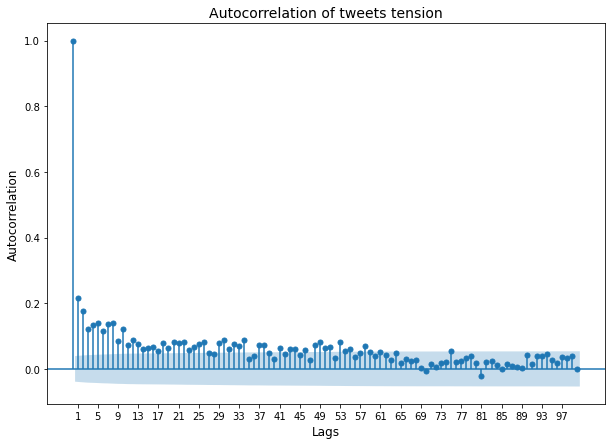

In [280]:
plt.rc("figure", figsize=(10, 7))
stm_plots.plot_acf(ts_train_diff, lags = 100)
plt.xlabel('Lags', fontsize=12)
plt.xticks([_ for _ in range(1, 101, 4)])
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of tweets tension', fontsize=14)
plt.show()

From the plot above we can identify the model ARMA(0, 53) (or ARIMA(0, 1, 53)), because further autocorrelations are not significant (the significance level is equal to 0.05). But it's too complicated model, so we omit that model in further considerations.

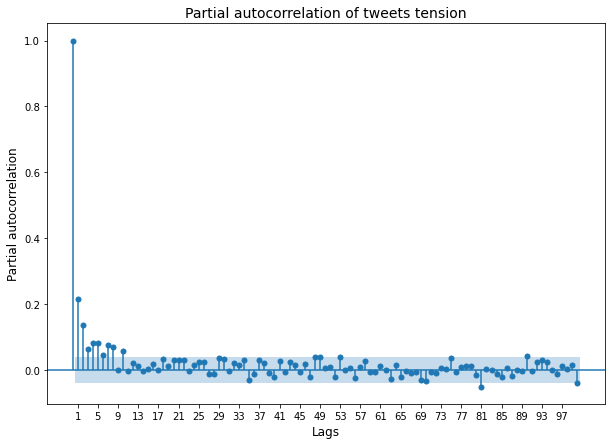

In [281]:
plt.rc("figure", figsize=(10, 7))
stm_plots.plot_pacf(ts_train_diff, lags = 100)
plt.xlabel('Lags', fontsize=12)
plt.xticks([_ for _ in range(1, 101, 4)])
plt.ylabel('Partial autocorrelation', fontsize=12)
plt.title('Partial autocorrelation of tweets tension', fontsize=14)
plt.show()

The plot above suggests to choose the ARMA(10,0) (ARIMA(10,1,0)) model, because further partial autocorrelations are not significant (the significance level is equal to 0.05). Now we use auto_arima function to find the ARMA($p$, $q$) model, where $p$, $q$ are greater than zero in the same time.

In [282]:
arima_model_fitted = pmdarima.auto_arima(ts_train)

In [283]:
arima_model_fitted

ARIMA(order=(1, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Now we will compare the identified models:
* ARIMA(10,1,0),
* ARIMA(1, 2, 3),

using AIC and BIC criterions (goodnes-of-fit). But we will consider ARIMA(1, 1, 3), if we want to be able to compare these models - number of differentations must be the same, instead of ARIMA(1, 2 ,3) model.

In [284]:
arima_1_1_3 = pmdarima.auto_arima(ts_train, start_p=1, max_p=1, D=1, start_q=3, max_q=3)
arima_10_1_0 = pmdarima.auto_arima(ts_train, start_p=10, max_p=10, D=1, start_q=0, max_q=0)

In [285]:
arima_1_1_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2520
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -2495.583
Date:                Wed, 18 May 2022   AIC                           5001.166
Time:                        22:43:39   BIC                           5030.322
Sample:                             0   HQIC                          5011.747
                               - 2520                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8847      0.046     19.411      0.000       0.795       0.974
ma.L1         -1.7400      0.049    -35.377      0.000      -1.836      -1.644
ma.L2          0.7058      0.047     15.131      0.000       0.614       0.797
ma.L3          0.0372      0.022      1.708      0.088      -0.005       0.080
sigma2         0.4246      0.014     29.797      0.000       0.397       0.452
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                29.60
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [286]:
arima_10_1_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2520
Model:              SARIMAX(10, 2, 0)   Log Likelihood               -2542.268
Date:                Wed, 18 May 2022   AIC                           5106.537
Time:                        22:43:40   BIC                           5170.680
Sample:                             0   HQIC                          5129.815
                               - 2520                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8072      0.018    -44.669      0.000      -0.843      -0.772
ar.L2         -0.6756      0.024    -28.523      0.000      -0.722      -0.629
ar.L3         -0.6167      0.027    -22.632      0.000      -0.670      -0.563
ar.L4         -0.5263      0.029    -18.025      0.000      -0.584      -0.469
ar.L5         -0.4273      0.030    -14.366      0.000      -0.486      -0.369
ar.L6         -0.3685      0.030    -12.406      0.000      -0.427      -0.310
ar.L7         -0.2689      0.029     -9.232      0.000      -0.326      -0.212
ar.L8         -0.1662      0.028     -5.975      0.000      -0.221      -0.112
ar.L9         -0.1395      0.024     -5.701      0.000      -0.188      -0.092
ar.L10        -0.0424      0.019     -2.183      0.029      -0.080      -0.004
sigma2         0.4408      0.014     32.517      0.000       0.414       0.467
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                11.24
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model arima_1_1_3 is better - the AIC and BIC values are smaller than for arima_10_1_0

Let's plot autocorrelation estimator for squared residuals of fitted model.

In [287]:
res_squared = arima_1_1_3.arima_res_.resid**2

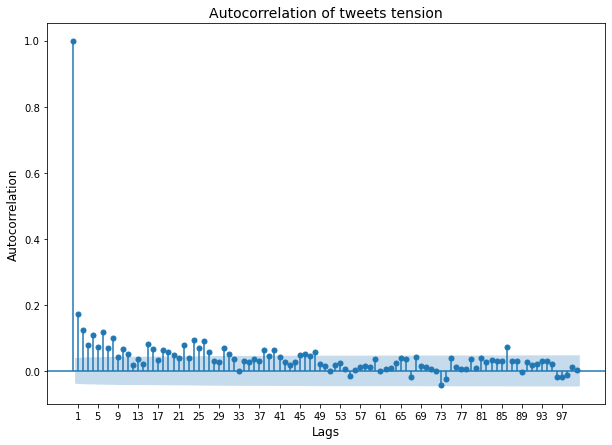

In [288]:
plt.rc("figure", figsize=(10, 7))
stm_plots.plot_acf(res_squared, lags = 100)
plt.xlabel('Lags', fontsize=12)
plt.xticks([_ for _ in range(1, 101, 4)])
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of tweets tension', fontsize=14)
plt.show()

On the plot above we can see volatility clusters (except value for first lag - it is equal to one from definition). Autocorrelations should be non-significant, but they aren't. It's good idea to model conditional variance and we use the GARCH(1,1) model in this purpose.

In [289]:
ts_res = pd.DataFrame(data = arima_1_1_3.arima_res_.resid, index = ts_train.index, columns = ['res'])
ts_res.head(10)

,res
created_at,
2022-04-15 21:02:01,-1.000000
2022-04-15 21:02:23,-0.500000
2022-04-15 21:04:04,1.000000
2022-04-15 21:04:19,0.467681
2022-04-15 21:04:21,-0.687839
2022-04-15 21:05:14,-0.455421
2022-04-15 21:05:17,-0.354905
2022-04-15 21:05:58,0.714625
2022-04-15 21:06:49,1.535345


Fitting the GARCH(1,1) model.

In [290]:
garch = arch.arch_model(ts_res, vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 10757.63771534754
Iteration:      2,   Func. Count:     15,   Neg. LLF: 479502.72074379644
Iteration:      3,   Func. Count:     22,   Neg. LLF: 2590.670121565917
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2464.090947155526
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2443.279404758565
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2443.2205786857444
Iteration:      7,   Func. Count:     47,   Neg. LLF: 2443.220578684647
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2443.2205786857444
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 7


## Forecasting

In [291]:
ts_test.index = np.array(ts_test.index, dtype=np.datetime64)

In [292]:
predicted_et = garch_fitted.forecast(horizon = ts_test.shape[0]).mean.iloc[-1]
predicted_et = np.array(predicted_et)

In [293]:
predicted_mu = arima_1_1_3.predict(n_periods = len(ts_test))
predicted_mu = np.array(predicted_mu)

In [309]:
# Formula for prediction for combination of the ARIMA and GARCH models
prediction = predicted_mu + predicted_et

In [311]:
ts_predicted = pd.DataFrame(data = prediction, index = ts_test.index, columns = ['predicted'])

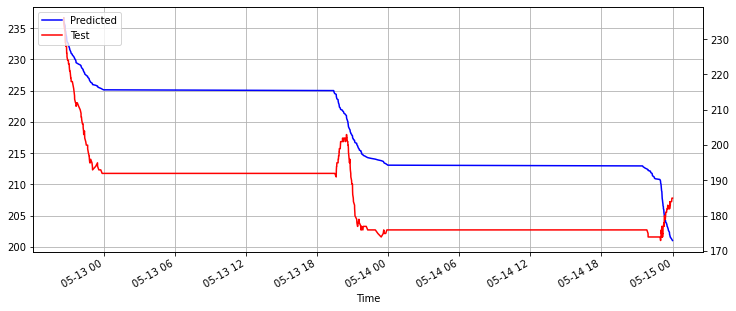

In [312]:
plt.figure(figsize=(12,5))
plt.xlabel('Time')

ax1 = ts_predicted['predicted'].plot(color='blue', grid=True, label='Predicted')
ax2 = ts_test['moving_tension'].plot(color='red', grid=True, secondary_y=True, label='Test')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()